<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-imports-and-dfs" data-toc-modified-id="Load-imports-and-dfs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load imports and dfs</a></span></li></ul></div>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 4
%autosave 120

Autosaving every 120 seconds


1. Load imports & test, train DFs
2. Apply stratified kfold & traing with lgbm and submit to kaggle
3. Check for missing data feature engineering parts missed if score > 3.7
4. Split the training set to train & validation
5. Train over RF to get a benchmark of the dataset
6. Drop irrelevant features by sorting on feature importance
7. Drop redundant features by plotting a Dendogram and removing the redundancy
8. Use a feature interpreter to see which feature is contributing lot to prediction
9. Use extrapolation to see if we can remove feature which add bias of training & validation set
10. Use partial dependence plot to see outliers/missed features
11. Submit to kaggle the RF model and see the score
11. Use stratified kfold to train the RF model and submit to kaggle
12. Repeat again with LGBM/XGBoost/Adaboost. Stack the model and submit to kaggle


### Load imports and dfs

In [2]:
from fastai.io import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from pandas_summary import DataFrameSummary
from IPython.display import display
from sklearn import metrics
import feather
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings

In [3]:
train_df2 = feather.read_dataframe('train_df')
test_df2 = feather.read_dataframe('test_df')

In [4]:
for df in [train_df2, test_df2]:
    for f in ['purchase_date_max','purchase_date_min','purchase_date_max_old',\
                     'purchase_date_min_old']:
        df[f] = df[f].astype(np.int64) * 1e-9

In [5]:
del_cols = ['first_active_monthIs_month_start', 'authorized_flag_1_mean', 'first_active_monthIs_year_start',
       'first_active_monthIs_year_end', 'first_active_monthIs_quarter_end', 'avg_trans_per_merchant',
       'first_active_monthIs_month_end', 'first_active_monthDay', 'card_id_size',
       'authorized_flag_1_amount_mean_mean', 'authorized_flag_1_amount_sum_sum','card_id', 'first_active_month','target','outliers']

In [6]:
def one_hot_encode_fe(df):
    return pd.get_dummies(df, columns=['feature_1', 'feature_2', 'feature_3'])

In [7]:
# [train_df2, test_df2] = [one_hot_encode_fe(d) for d in [train_df2, test_df2]]

In [8]:
df_train_columns = [c for c in train_df2.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = train_df2['target']

In [9]:
train_df2.shape, test_df2.shape

((201917, 116), (123623, 114))

In [10]:
target.shape

(201917,)

In [11]:
del train_df2['target']

In [12]:
len(df_train_columns)

112

In [13]:
from scipy.stats import ks_2samp
list_p_value =[]

for i in tqdm(df_train_columns):
    list_p_value.append(ks_2samp(test_df2[i] , train_df2[i])[1])

Se = pd.Series(list_p_value, index = df_train_columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

100%|██████████| 112/112 [00:02<00:00, 37.73it/s]


In [14]:
list_discarded

['avg_spend_per_transaction',
 'purchase_amount_mean',
 'avg_spend_per_merchant',
 'purchase_amount_max_old',
 'category_3_amount_mean_mean_old',
 'purchase_amount_sum']

In [106]:
df_train_columns = [c for c in df_train_columns if c not in list_discarded]

In [28]:
len(df_train_columns)

116

In [50]:
# train_df2.fillna(0, inplace=True)
# test_df2.fillna(0, inplace=True)

In [15]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(train_df2))
predictions = np.zeros(len(test_df2))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df2,train_df2['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df2.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train_df2.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train_df2.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df2[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.67049	valid_1's rmse: 3.7261
[200]	training's rmse: 3.59426	valid_1's rmse: 3.69365
[300]	training's rmse: 3.54711	valid_1's rmse: 3.67976
[400]	training's rmse: 3.51154	valid_1's rmse: 3.67307
[500]	training's rmse: 3.48146	valid_1's rmse: 3.66758
[600]	training's rmse: 3.45611	valid_1's rmse: 3.66441
[700]	training's rmse: 3.43308	valid_1's rmse: 3.66218
[800]	training's rmse: 3.41305	valid_1's rmse: 3.66122
[900]	training's rmse: 3.39543	valid_1's rmse: 3.65974
[1000]	training's rmse: 3.37818	valid_1's rmse: 3.65959
[1100]	training's rmse: 3.36269	valid_1's rmse: 3.65869
[1200]	training's rmse: 3.34563	valid_1's rmse: 3.65902
Early stopping, best iteration is:
[1100]	training's rmse: 3.36269	valid_1's rmse: 3.65869
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.67157	valid_1's rmse: 3.71674
[200]	training's rmse: 3.59538	valid_1's rmse: 3.686

3.6613110690115453

1. Score for submission-2019-01-11 10:18:09.909061.csv - 3.6597596743401666, LB - 3.707 (included cat_1)
2. Score for submission-2019-01-12 13:53:27.215115.csv - 3.656726211308068, LB - 3.696 (jst refactored)
3. No changes what so ever - 3.6627995460091523
4. Replaced with kernels code - 3.6623128394907103
5. Replaced with kernels code along with cat_2 mean - 3.6609564684554594
6. Added extra feature - 3.6559302073797637, LB - 3.696 (No grouping by auth flag and all)
7. Added aggs on cat_1, auth - 3.6554801486969906, LB- 3.696
8. Removed unnecessary cols - 3.6556548946965446, LB - 3.696
9. Removed aggs on cat_1 - 3.654208034404632, LB - 3.697
10. Removed unnecessary del_cols - 3.65493381575084, LB - 3.697
11. One hot encoded features - 3.6558286566186897
12. Added monthly aggregates - 3.653533666238162, LB - 3.716
13. Removed some monthly aggregates - 3.654769374794982, LB - 3.707
14. reverting to earlier checkpoing - 3.65377489489624
15. Benchmarks - LGBM - 3.654910478618945, DL - 3.6971527526968155
16. Aggregated on cat_1, cat_2, cat_3 - 3.6613473953411266, LB - 3.734
17. Aggregated on authorized trans - 3.660471359804697, LB - 
18. Removed filling of NaNs with 0s in cat aggregates - 3.6613219418574943, 
19. Filling NaNs with 0s for all df values - 3.662186022939442
20. Removed cat aggs - agg only on authorized - 3.6612178198254326

/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


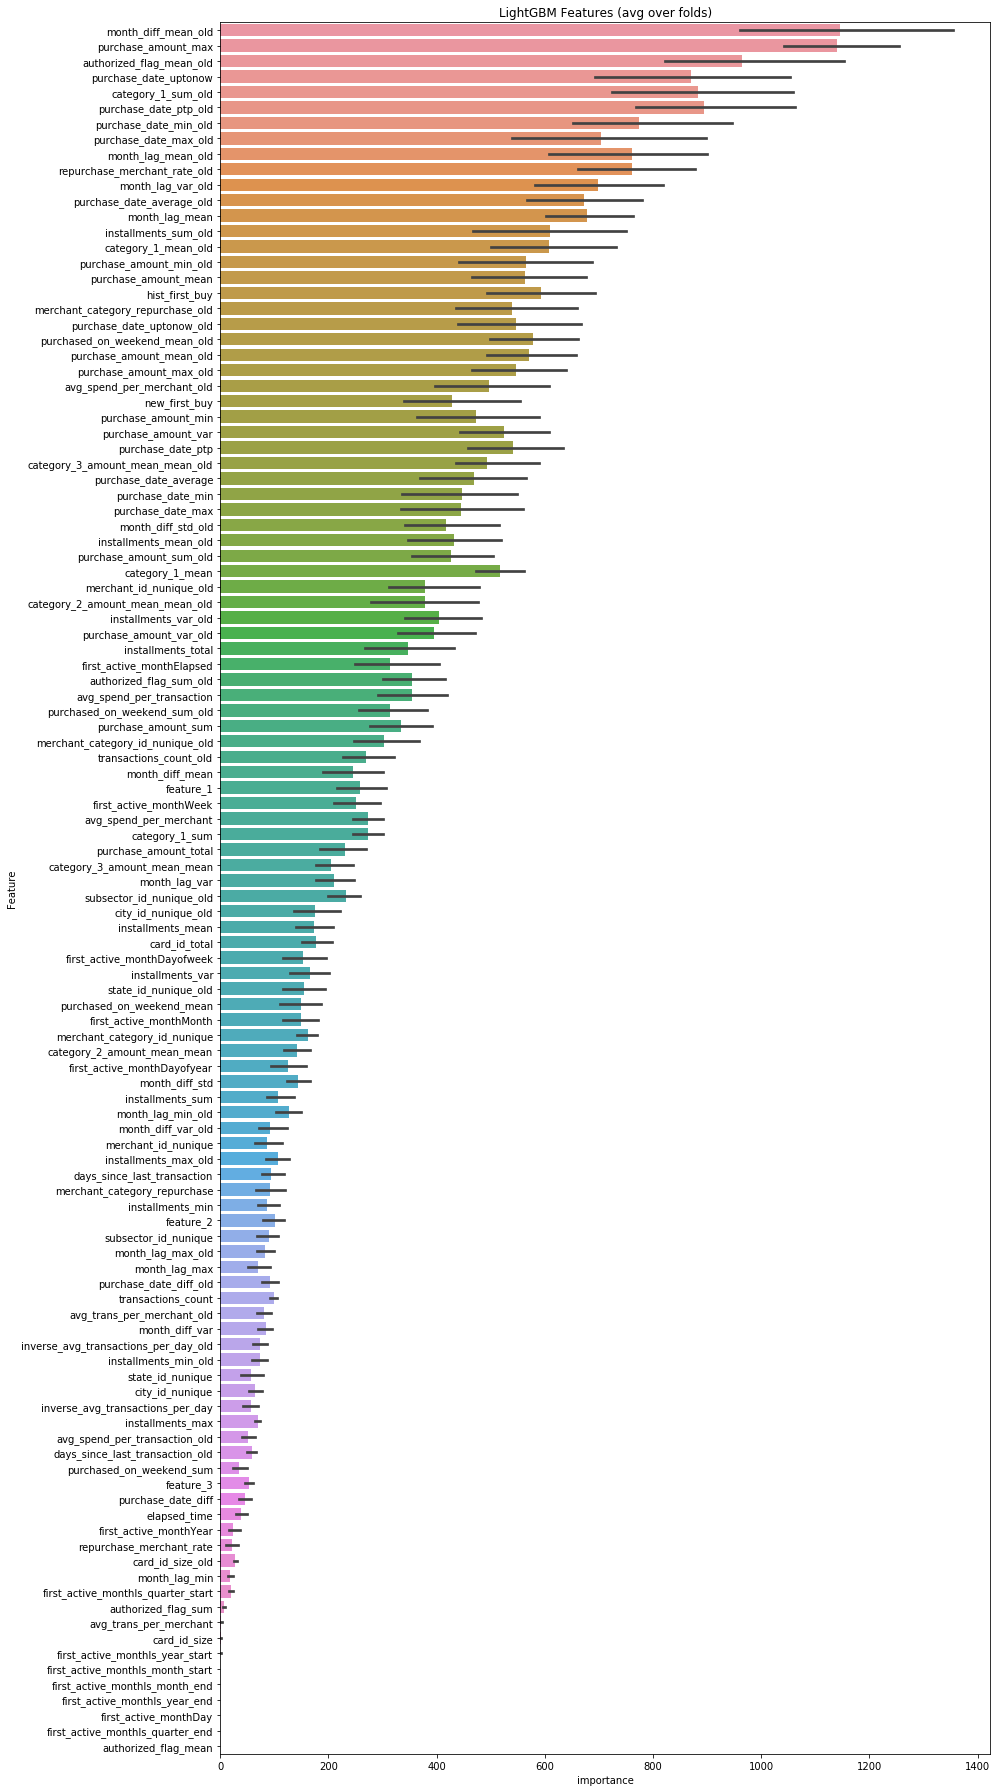

In [16]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [17]:
best_features.sort_values(by='importance', ascending=True)[:50]['Feature'].unique()

array(['first_active_monthIs_month_end', 'first_active_monthIs_month_start',
       'first_active_monthIs_quarter_end', 'card_id_size', 'first_active_monthIs_year_end',
       'first_active_monthIs_year_start', 'authorized_flag_mean', 'first_active_monthDay',
       'avg_trans_per_merchant', 'repurchase_merchant_rate', 'authorized_flag_sum'], dtype=object)

In [18]:
sub_df = pd.DataFrame({"card_id":test_df2["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv(f'submission-{pd.to_datetime("today")}.csv', index=False)

In [19]:
!ls

'Elo - ML model - cat aggregates.ipynb'
'Elo - ML model clean.ipynb'
'Elo - ML model proc_df.ipynb'
'Elo - ML model-RF copy.ipynb'
'Elo - ML model-backup.ipynb'
'Elo - ML model-new.ipynb'
'Elo - ML model.ipynb'
'Elo RF- New.ipynb'
'Elo RF.ipynb'
'Elo end 2 end.ipynb'
'Elo feature engineering using agg.ipynb'
'Elo feature engineering-backup.ipynb'
'Elo feature engineering-proc_df - new-Copy1.ipynb'
'Elo feature engineering-proc_df - new.ipynb'
'Elo feature engineering-proc_df-OLD.ipynb'
'Elo feature engineering.ipynb'
'Elo merchant category reco - using RF.ipynb'
 README.md
'Scrap pad.ipynb'
'Scrap pad.py'
'TS Fresh.ipynb'
'TS Fresh.py'
'Train & test clean.ipynb'
'Using DL.ipynb'
'Using Feature tools.ipynb'
 adf
 authorised_trans_proc_agg
 cols_keep.npy
 data
 df_auth
 df_hot_dropped_all
 df_hot_ext
 df_hot_test
 df_hot_test_ext
 df_new
 df_non_auth
 df_proc_dfed
 df_test_n_o
 df_xo
 fastai
 fm_new_hist
 hist_trans
 hist_trans_agg
 hist_trans_agg_n
 hist_trans_agg_proc
 lgbm_importances

In [16]:
FileLink('./submission-2019-01-20 00:30:10.643280.csv')

/home/chandrasekhar/private/kaggle/submission-2019-01-20 00:30:10.643280.csv